In [27]:
# -----------------------------------------------------------------
# Cell 1: Import All Necessary Libraries
# -----------------------------------------------------------------
import pandas as pd                 # For data manipulation and CSV file I/O (like Excel for Python)
import numpy as np                  # For scientific computing, especially array operations
import matplotlib.pyplot as plt     # For creating basic charts
import seaborn as sns               # For creating prettier, more advanced statistical charts (based on matplotlib)

# Import our tools from scikit-learn (sklearn) library
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler      # For data standardization (feature scaling)

# Import regression models
from sklearn.linear_model import LinearRegression     # Linear Regression (basic model)
from sklearn.ensemble import RandomForestRegressor    # Random Forest (advanced model)

# Import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score # For evaluating regression model performance

# Set plotting style (for prettier visualizations)
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # Used to display Chinese labels normally
plt.rcParams['axes.unicode_minus'] = False  # Used to display minus sign normally

print("All libraries imported successfully!")

All libraries imported successfully!


In [28]:
# -----------------------------------------------------------------
# Cell 2: Load Data (Processed in Weka)
# -----------------------------------------------------------------

# Load data for prediction, classification, and clustering
# This is the data after we added 'Energy_Efficiency' (and discretized it) in Weka
try:
    df = pd.read_csv('dataset_preprocessed.csv')
except FileNotFoundError:
    print("Error: 'dataset_preprocessed.csv' file not found.")
    print("Please ensure the file is in the same directory as your Notebook.")

# Load data for association analysis
# This is the data after we discretized multiple features in Weka
try:
    df_assoc = pd.read_csv('dataset_for_association.csv')
except FileNotFoundError:
    print("Error: 'dataset_for_association.csv' file not found.")
    print("Please ensure the file is in the same directory as your Notebook.")


# Print data info to ensure Weka's processing was read correctly
if 'df' in locals():
    print("--- 'dataset_preprocessed.csv' (Main Data) Load Info ---")
    print(df.info())
    print("\n--- 'dataset_preprocessed.csv' (Main Data) Preview (First 5 rows) ---")
    print(df.head())

--- 'dataset_preprocessed.csv' (Main Data) Load Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Server_Workload                 3498 non-null   float64
 1   Inlet_Temperature               3498 non-null   float64
 2   Outlet_Temperature              3498 non-null   float64
 3   Ambient_Temperature             3498 non-null   float64
 4   Cooling_Unit_Power_Consumption  3498 non-null   float64
 5   Chiller_Usage                   3498 non-null   float64
 6   AHU_Usage                       3498 non-null   float64
 7   Total_Energy_Cost               3498 non-null   float64
 8   Temperature_Deviation           3498 non-null   float64
 9   Cooling_Strategy_Action         3498 non-null   object 
 10  Output                          3498 non-null   int64  
 11  Energy_Efficiency               3498 n

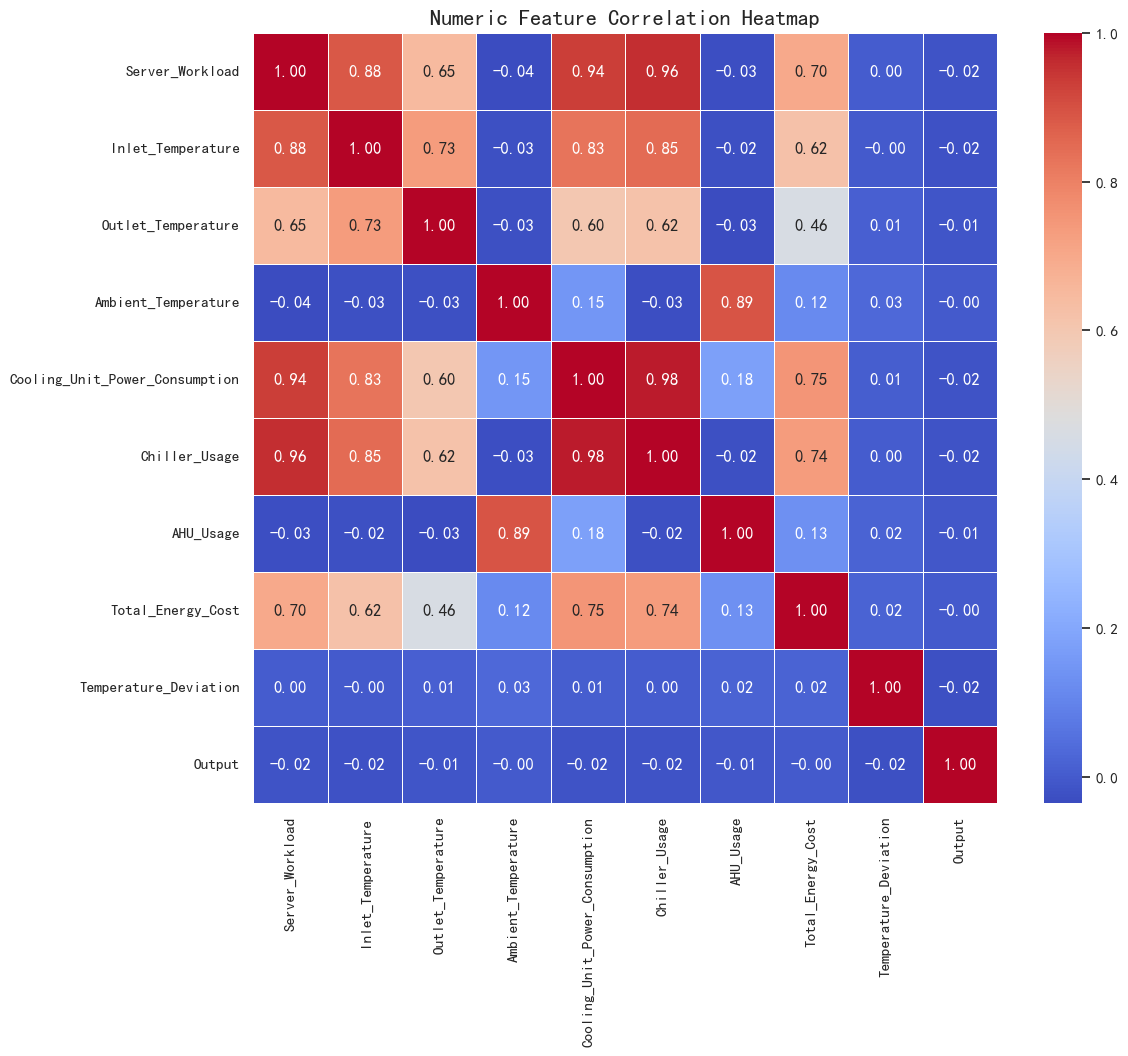

In [29]:
# -----------------------------------------------------------------
# Cell 3: Plot Correlation Heatmap for Numeric Features (EDA)
# -----------------------------------------------------------------

# 1. Select all numeric columns for correlation calculation
# (Correlation matrix can only be computed between numbers)
numeric_features = df.select_dtypes(include=np.number)

# 2. Calculate the correlation matrix
corr_matrix = numeric_features.corr()

# 3. Plot the heatmap
plt.figure(figsize=(12, 10)) # Set the figure size
sns.heatmap(
    corr_matrix,          # The data to plot
    annot=True,             # Show numbers on the cells
    cmap='coolwarm',        # Use 'cool-warm' colormap (Red=Positive Corr, Blue=Negative Corr)
    fmt='.2f',              # Number format (2 decimal places)
    linewidths=0.5          # Width of lines between cells
)
plt.title('Numeric Feature Correlation Heatmap', fontsize=16)
plt.show()

In [30]:
# -----------------------------------------------------------------
# Cell 4: Define Features (X) and Target (y), and Split Dataset
# -----------------------------------------------------------------

# 1. Define Target (y)
# Our target is two columns
targets_y = df[['Cooling_Unit_Power_Consumption', 'Temperature_Deviation']]

# 2. Define Features (X)
# Features are all input columns used for prediction
# We must remove the target columns themselves, and the classification labels we created in Weka
features_X = df.drop(columns=[
    'Cooling_Unit_Power_Consumption',  # This is a target
    'Temperature_Deviation',           # This is also a target
    'Energy_Efficiency',               # This is the target for the classification task
    'Cooling_Strategy_Action',         # This is a categorical label
    'Output'                           # This is a categorical label
])

# 3. Split into Training and Test Sets
# We split the data into "homework" (training set) and "exam" (test set)
# 70% of data for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    features_X,    # Features
    targets_y,     # Target
    test_size=0.3, # 30% for the test set
    random_state=42 # Random seed, ensures the split is the same every time for reproducibility
)

# Print the shapes of the split data
print("--- Dataset Split Results ---")
print(f"X_train (Training Features) Shape: {X_train.shape}")
print(f"X_test (Test Features) Shape: {X_test.shape}")
print(f"y_train (Training Target) Shape: {y_train.shape}")
print(f"y_test (Test Target) Shape: {y_test.shape}")

--- Dataset Split Results ---
X_train (Training Features) Shape: (2448, 7)
X_test (Test Features) Shape: (1050, 7)
y_train (Training Target) Shape: (2448, 2)
y_test (Test Target) Shape: (1050, 2)


In [31]:
# -----------------------------------------------------------------
# Cell 5: Data Standardization
# -----------------------------------------------------------------

# 1. Create a standardization "Scaler"
scaler = StandardScaler()

# 2. "Learn" the mean and standard deviation on the training set (X_train)
#    and "transform" X_train
#    Note: Use .fit_transform()
X_train_scaled = scaler.fit_transform(X_train)

# 3. "Apply" the same transformation to the test set (X_test)
#    Note: Only use .transform(), do not "learn" again
X_test_scaled = scaler.transform(X_test)

print("Data standardization complete.")
print(f"Mean before standardization (X_train example): {X_train['Server_Workload'].mean():.2f}")
print(f"Mean after standardization (X_train_scaled example): {X_train_scaled[:, 0].mean():.2f}") # Close to 0

Data standardization complete.
Mean before standardization (X_train example): 65.26
Mean after standardization (X_train_scaled example): -0.00


In [32]:
# -----------------------------------------------------------------
# Cell 6: Train and Evaluate "Model 1: Linear Regression"
# -----------------------------------------------------------------

# 1. Create the model
#    (n_jobs=-1 means use all CPU cores to speed up)
lr_model = LinearRegression(n_jobs=-1)

# 2. Train the model
#    (Using the standardized training data)
print("Training Linear Regression model...")
lr_model.fit(X_train_scaled, y_train)
print("Training complete.")

# 3. Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_scaled)

# 4. Evaluate the model (compare with the true answers, y_test)
print("\n--- Linear Regression Evaluation Results ---")

# Evaluate Target 1: Power Consumption
r2_lr_power = r2_score(y_test['Cooling_Unit_Power_Consumption'], y_pred_lr[:, 0])
mse_lr_power = mean_squared_error(y_test['Cooling_Unit_Power_Consumption'], y_pred_lr[:, 0])
print(f"[Power (kW)]\t R-squared: {r2_lr_power:.4f} | MSE: {mse_lr_power:.4f}")

# Evaluate Target 2: Temperature Deviation
r2_lr_temp = r2_score(y_test['Temperature_Deviation'], y_pred_lr[:, 1])
mse_lr_temp = mean_squared_error(y_test['Temperature_Deviation'], y_pred_lr[:, 1])
print(f"[Temp Deviation (°C)]\t R-squared: {r2_lr_temp:.4f} | MSE: {mse_lr_temp:.4f}")

Training Linear Regression model...
Training complete.

--- Linear Regression Evaluation Results ---
[Power (kW)]	 R-squared: 0.9997 | MSE: 0.0000
[Temp Deviation (°C)]	 R-squared: -0.0005 | MSE: 2.8392


In [33]:
# -----------------------------------------------------------------
# Cell 7: Train and Evaluate "Model 2: Random Forest Regressor"
# -----------------------------------------------------------------

# 1. Create the model
#    n_estimators=100 means it will build 100 decision trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model
#    (Random Forest is not very sensitive to data standardization, but using standardized data is fine)
print("Training Random Forest model (this may take a few seconds)...")
rf_model.fit(X_train_scaled, y_train)
print("Training complete.")

# 3. Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Evaluate the model
print("\n--- Random Forest Evaluation Results ---")

# Evaluate Target 1: Power Consumption
r2_rf_power = r2_score(y_test['Cooling_Unit_Power_Consumption'], y_pred_rf[:, 0])
mse_rf_power = mean_squared_error(y_test['Cooling_Unit_Power_Consumption'], y_pred_rf[:, 0])
print(f"[Power (kW)]\t R-squared: {r2_rf_power:.4f} | MSE: {mse_rf_power:.4f}")

# Evaluate Target 2: Temperature Deviation
r2_rf_temp = r2_score(y_test['Temperature_Deviation'], y_pred_rf[:, 1])
mse_rf_temp = mean_squared_error(y_test['Temperature_Deviation'], y_pred_rf[:, 1])
print(f"[Temp Deviation (°C)]\t R-squared: {r2_rf_temp:.4f} | MSE: {mse_rf_temp:.4f}")

Training Random Forest model (this may take a few seconds)...
Training complete.

--- Random Forest Evaluation Results ---
[Power (kW)]	 R-squared: 0.9551 | MSE: 0.0011
[Temp Deviation (°C)]	 R-squared: 0.9996 | MSE: 0.0011


--- Overall Feature Importance (Random Forest) ---
               Feature  Importance
3  Ambient_Temperature    0.991276
4        Chiller_Usage    0.007273
0      Server_Workload    0.000780
1    Inlet_Temperature    0.000213
2   Outlet_Temperature    0.000187
5            AHU_Usage    0.000146
6    Total_Energy_Cost    0.000125


C:\Users\无艺\AppData\Local\Temp\ipykernel_4672\2408576416.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


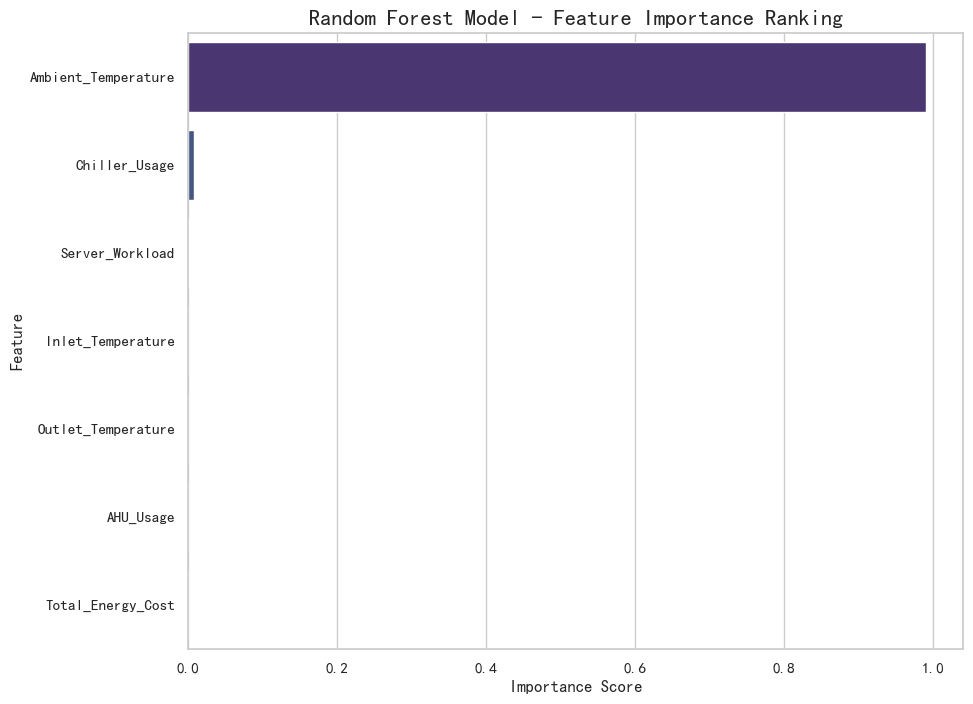

In [34]:
# -----------------------------------------------------------------
# Cell 8: Analyze Random Forest "Feature Importance"
# -----------------------------------------------------------------

# After training, a Random Forest model stores a 'feature_importances_' attribute
# Note: For multi-output models, feature_importances_ is the average importance across all outputs.
#       For a clearer analysis, we could train separate models, but here we'll look at the overall importance.

importances = rf_model.feature_importances_
feature_names = features_X.columns # Get the feature names

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Sort by importance, descending

print("--- Overall Feature Importance (Random Forest) ---")
print(importance_df)

# Plot a bar chart
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    palette='viridis'
)
plt.title('Random Forest Model - Feature Importance Ranking', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [35]:
# -----------------------------------------------------------------
# Cell 9: Preprocessing (Replicating Weka Steps in Python)
# -----------------------------------------------------------------

# 1. Load the "raw" data
df_raw = pd.read_csv('dataset_no_units.csv')
print("Raw data 'dataset_no_units.csv' loaded successfully.")

# 2. Feature Engineering (Weka: AddExpression)
#    Create 'Energy_Efficiency'
#    Formula: Server_Workload / (Cooling_Unit_Power_Consumption + 0.001)
df_raw['Energy_Efficiency'] = df_raw['Server_Workload'] / (df_raw['Cooling_Unit_Power_Consumption'] + 0.001)

# 3. Discretization (Weka: Discretize)
#    We use pd.qcut, which is the perfect equivalent to "useEqualFrequency=True" (equal frequency binning) in Weka
df_raw['Energy_Efficiency_Class'] = pd.qcut(
    df_raw['Energy_Efficiency'],
    q=3,
    labels=['Low', 'Medium', 'High'] # labels
)

print("\n--- (New) Target Variable Distribution after Python Preprocessing ---")
# Print the distribution of the newly created target variable 'Energy_Efficiency_Class'
print(df_raw['Energy_Efficiency_Class'].value_counts())

Raw data 'dataset_no_units.csv' loaded successfully.

--- (New) Target Variable Distribution after Python Preprocessing ---
Energy_Efficiency_Class
Low       1166
Medium    1166
High      1166
Name: count, dtype: int64


In [36]:
# -----------------------------------------------------------------
# Cell 10: Prepare Classification Data (X, y, Split)
# -----------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Define Target (y)
y = df_raw['Energy_Efficiency_Class']

# 2. Define Features (X)
# Remove all target columns, class labels, identifiers
X = df_raw.drop(columns=[
    'Timestamp',
    'Cooling_Unit_Power_Consumption',
    'Temperature_Deviation',
    'Energy_Efficiency',               # (We're using the discrete 'Energy_Efficiency_Class')
    'Energy_Efficiency_Class',         # (This is y)
    'Cooling_Strategy_Action',
    'Output'
])

print("\n--- Features (X) for Classification ---")
print(X.columns.tolist())

# 3. Split into Training and Test Sets (for classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42,
    stratify=y  # **Key**: Ensures the proportion of efficiency classes is the same in train and test sets
)

# 4. Standardize Data (for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData splitting and standardization complete.")


--- Features (X) for Classification ---
['Server_Workload', 'Inlet_Temperature', 'Outlet_Temperature', 'Ambient_Temperature', 'Chiller_Usage', 'AHU_Usage', 'Total_Energy_Cost']

Data splitting and standardization complete.


In [37]:
# -----------------------------------------------------------------
# Cell 11: Model 1 - Decision Tree (Weka J48/C4.5)
# -----------------------------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

print("\n--- Train & Evaluate: Model 1 (Decision Tree) ---")
# criterion='entropy' corresponds to Weka J48's information gain
# max_depth=5 limits the tree depth, prevents overfitting, and makes it more readable
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train) # Train on "unstandardized" data for more readable rules
y_pred_dt = dt_model.predict(X_test)

print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))


--- Train & Evaluate: Model 1 (Decision Tree) ---
Decision Tree Accuracy: 0.7552
Decision Tree Classification Report:
              precision    recall  f1-score   support

        High       0.78      0.77      0.78       350
         Low       0.90      0.79      0.84       350
      Medium       0.62      0.71      0.66       350

    accuracy                           0.76      1050
   macro avg       0.77      0.76      0.76      1050
weighted avg       0.77      0.76      0.76      1050



In [38]:
# -----------------------------------------------------------------
# Cell 12: Visualize the Decision Tree
# -----------------------------------------------------------------

from sklearn.tree import plot_tree
plt.figure(figsize=(25, 15))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=dt_model.classes_,
    filled=True, rounded=True, fontsize=10
)
plt.title("Decision Tree (Energy Efficiency Classification) - Max Depth 5", fontsize=20)
plt.savefig("decision_tree.png", dpi=150, bbox_inches='tight')
plt.close()

In [39]:
# -----------------------------------------------------------------
# Cell 13: Model 2 - Random Forest
# -----------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
print("\n--- Train & Evaluate: Model 2 (Random Forest) ---")
rf_class_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_class_model.fit(X_train, y_train) # Also train on "unstandardized" data
y_pred_rf = rf_class_model.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


--- Train & Evaluate: Model 2 (Random Forest) ---
Random Forest Accuracy: 0.8933
Random Forest Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.89      0.91       350
         Low       0.92      0.95      0.93       350
      Medium       0.84      0.83      0.84       350

    accuracy                           0.89      1050
   macro avg       0.89      0.89      0.89      1050
weighted avg       0.89      0.89      0.89      1050



In [40]:
# -----------------------------------------------------------------
# Cell 14: Model 3 - Logistic Regression
# -----------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
print("\n--- Train & Evaluate: Model 3 (Logistic Regression - Baseline) ---")
lr_class_model = LogisticRegression(random_state=42, max_iter=1000)
# **Note**: Logistic Regression "must" use standardized data
lr_class_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_class_model.predict(X_test_scaled)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


--- Train & Evaluate: Model 3 (Logistic Regression - Baseline) ---
Logistic Regression Accuracy: 0.9638
Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.99      0.96      0.97       350
         Low       0.97      0.98      0.97       350
      Medium       0.94      0.96      0.95       350

    accuracy                           0.96      1050
   macro avg       0.96      0.96      0.96      1050
weighted avg       0.96      0.96      0.96      1050



In [41]:
# -----------------------------------------------------------------
# Cell 15: Classification Model Feature Importance
# -----------------------------------------------------------------

# Generate classification_importance.png
print("\nAnalyzing classification model feature importance...")
importances_c = rf_class_model.feature_importances_
feature_names_c = X.columns
c_importance_df = pd.DataFrame({
    'Feature': feature_names_c,
    'Importance': importances_c
}).sort_values(by='Importance', ascending=False)

print("\n--- Classification Model Feature Importance Ranking ---")
print(c_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=c_importance_df, palette='rocket')
plt.title('Random Forest Classifier - Feature Importance', fontsize=16)
plt.savefig("classification_importance.png", dpi=150, bbox_inches='tight')
plt.close()


Analyzing classification model feature importance...

--- Classification Model Feature Importance Ranking ---
               Feature  Importance
0      Server_Workload    0.324733
4        Chiller_Usage    0.191296
1    Inlet_Temperature    0.146652
5            AHU_Usage    0.125791
3  Ambient_Temperature    0.090327
2   Outlet_Temperature    0.081587
6    Total_Energy_Cost    0.039614


C:\Users\无艺\AppData\Local\Temp\ipykernel_4672\387695150.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=c_importance_df, palette='rocket')


In [42]:
# -----------------------------------------------------------------
# Cell 17: Select and Standardize Features for Clustering
# -----------------------------------------------------------------

from sklearn.preprocessing import StandardScaler

# 1. Select features for clustering
cluster_features = [
    'Server_Workload',                # Workload
    'Ambient_Temperature',            # Ambient Temp
    'Cooling_Unit_Power_Consumption', # Power Consumption
    'Chiller_Usage',                  # Chiller
    'AHU_Usage',                      # AHU
    'Inlet_Temperature'               # Inlet Temp
]

# (Extract these columns from df_raw, which we loaded earlier)
df_cluster = df_raw[cluster_features]
print(f"Features for clustering: {cluster_features}")

# 2. Standardize data (K-Means requires this step)
scaler_cluster = StandardScaler()
df_cluster_scaled = scaler_cluster.fit_transform(df_cluster)
print("Clustering feature standardization complete.")

Features for clustering: ['Server_Workload', 'Ambient_Temperature', 'Cooling_Unit_Power_Consumption', 'Chiller_Usage', 'AHU_Usage', 'Inlet_Temperature']
Clustering feature standardization complete.


In [43]:
# -----------------------------------------------------------------
# Cell 18: Find the Optimal Number of Clusters 'k' (Elbow Method)
# -----------------------------------------------------------------

from sklearn.cluster import KMeans

inertia_values = [] # Store "Within-Cluster Sum of Squares" (WCSS)
possible_k_values = range(1, 11) # Test k from 1 to 10

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia_values.append(kmeans.inertia_) # inertia_ is WCSS

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia_values, 'bo-')
plt.title('Elbow Method for Finding Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.xticks(possible_k_values)
plt.grid(True)
plt.savefig("clustering_elbow_plot.png", dpi=150)
plt.close()

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a

In [44]:
# -----------------------------------------------------------------
# Cell 19: Train Final K-Means Model (k=4)
# -----------------------------------------------------------------

from sklearn.metrics import silhouette_score

OPTIMAL_K = 4
print(f"\n--- Training K-Means Model (k={OPTIMAL_K}) ---")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
kmeans_final.fit(df_cluster_scaled)
cluster_labels = kmeans_final.labels_

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df_cluster_scaled, cluster_labels)
print(f"Model Silhouette Score: {silhouette_avg:.4f}")


--- Training K-Means Model (k=4) ---


C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


Model Silhouette Score: 0.2886


In [45]:
# -----------------------------------------------------------------
# Cell 20: Analyze and Interpret Cluster Results (Core)
# -----------------------------------------------------------------

# 1. Add cluster labels back to the original DataFrame
df_analysis = df_cluster.copy()
df_analysis['Cluster'] = cluster_labels

# 2. Calculate the "Average Profile" for each cluster
cluster_profile = df_analysis.groupby('Cluster').mean()

print("\nCluster Profile (Mean values for each feature per cluster):")
print(cluster_profile)

# 3. Visualize the Cluster Profile (using a heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profile.T, # .T transposes the table, puts features on the Y-axis
    annot=True, fmt='.2f', cmap='viridis', linewidths=0.5
)
plt.title('Cluster Profile Heatmap (Mean Feature Values)', fontsize=16)
plt.savefig("clustering_profile_heatmap.png", dpi=150)
plt.close()


Cluster Profile (Mean values for each feature per cluster):
         Server_Workload  Ambient_Temperature  Cooling_Unit_Power_Consumption  \
Cluster                                                                         
0              89.168154            23.695827                        0.954685   
1              40.086801            24.076877                        0.558302   
2              65.719154            26.632287                        0.795137   
3              64.814581            21.379772                        0.727667   

         Chiller_Usage  AHU_Usage  Inlet_Temperature  
Cluster                                               
0            89.599083  47.563807          24.080846  
1            39.675194  48.166760          18.856089  
2            65.731917  53.852423          21.576527  
3            64.666619  42.090970          21.476165  


In [46]:
# -----------------------------------------------------------------
# Cell 21: Visualize Clusters (PCA Dimensionality Reduction)
# -----------------------------------------------------------------

from sklearn.decomposition import PCA

# 1. Use PCA to reduce 6 features down to 2 principal components
pca = PCA(n_components=2, random_state=42)
df_cluster_pca = pca.fit_transform(df_cluster_scaled)

# 2. Plot the scatter graph
pca_df = pd.DataFrame(data=df_cluster_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels # Color by cluster label

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', data=pca_df,
    palette='deep', alpha=0.7, s=50
)
plt.title('K-Means Clustering Results (PCA Visualization)', fontsize=16)
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig("clustering_pca_plot.png", dpi=150)
plt.close()

In [47]:
# -----------------------------------------------------------------
# Cell 23: Data Discretization
# -----------------------------------------------------------------
import pandas as pd
print("\n--- Preparing Association Analysis Data (Discretization) ---")

# (Assuming df_raw is already loaded from 'dataset_no_units.csv')
# df_raw = pd.read_csv('dataset_no_units.csv')

df_assoc = pd.DataFrame() # Create a new DataFrame

# 1. Discretize 'Ambient_Temperature' (Environmental parameter)
df_assoc['Ambient_Temp'] = pd.qcut(
    df_raw['Ambient_Temperature'],
    q=3, # Bin into 3 equal-frequency bins
    labels=['Ambient_Low', 'Ambient_Medium', 'Ambient_High']
)

# 2. Discretize 'Server_Workload' (Environmental parameter)
df_assoc['Workload'] = pd.qcut(
    df_raw['Server_Workload'],
    q=3,
    labels=['Workload_Low', 'Workload_Medium', 'Workload_High']
)

# 3. Discretize 'Cooling_Unit_Power_Consumption' (Our target)
df_assoc['Power'] = pd.qcut(
    df_raw['Cooling_Unit_Power_Consumption'],
    q=3,
    labels=['Power_Low', 'Power_Medium', 'Power_High']
)

print("Data discretization complete. Preview (First 5 rows):")
print(df_assoc.head())


--- Preparing Association Analysis Data (Discretization) ---
Data discretization complete. Preview (First 5 rows):
   Ambient_Temp       Workload       Power
0   Ambient_Low  Workload_High  Power_High
1  Ambient_High  Workload_High  Power_High
2   Ambient_Low   Workload_Low   Power_Low
3   Ambient_Low   Workload_Low   Power_Low
4  Ambient_High   Workload_Low   Power_Low


In [48]:
# -----------------------------------------------------------------
# Cell 24: One-Hot Encoding
# -----------------------------------------------------------------
print("\n--- Converting to 'One-Hot Encoded' Transaction Format ---")

# pd.get_dummies() will automatically handle this conversion
df_encoded = pd.get_dummies(df_assoc)

print("Encoding complete. Matrix shape (rows, columns):", df_encoded.shape)
print("Encoded preview (First 5 rows):")
print(df_encoded.head())


--- Converting to 'One-Hot Encoded' Transaction Format ---
Encoding complete. Matrix shape (rows, columns): (3498, 9)
Encoded preview (First 5 rows):
   Ambient_Temp_Ambient_Low  Ambient_Temp_Ambient_Medium  \
0                      True                        False   
1                     False                        False   
2                      True                        False   
3                      True                        False   
4                     False                        False   

   Ambient_Temp_Ambient_High  Workload_Workload_Low  Workload_Workload_Medium  \
0                      False                  False                     False   
1                       True                  False                     False   
2                      False                   True                     False   
3                      False                   True                     False   
4                       True                   True                     False   

 

In [49]:
# -----------------------------------------------------------------
# Cell 25: Run Apriori Algorithm to Find Frequent Itemsets
# -----------------------------------------------------------------
from mlxtend.frequent_patterns import apriori, association_rules

print("\n--- Running Apriori Algorithm ---")
# min_support=0.1 means we only care about
# "item" combinations that appear together at least 10% of the time
# (approx 350 hours)
frequent_itemsets = apriori(
    df_encoded,
    min_support=0.1,
    use_colnames=True # Use column names (e.g., 'Ambient_Low')
)

print(f"Found {len(frequent_itemsets)} frequent itemsets.")
print("\nTop 10 frequent itemsets by support:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))


--- Running Apriori Algorithm ---
Found 30 frequent itemsets.

Top 10 frequent itemsets by support:
     support                                  itemsets
6   0.346198                         (Power_Power_Low)
0   0.333333                (Ambient_Temp_Ambient_Low)
2   0.333333               (Ambient_Temp_Ambient_High)
3   0.333333                   (Workload_Workload_Low)
4   0.333333                (Workload_Workload_Medium)
1   0.333333             (Ambient_Temp_Ambient_Medium)
5   0.333333                  (Workload_Workload_High)
7   0.331904                      (Power_Power_Medium)
8   0.321898                        (Power_Power_High)
25  0.289022  (Workload_Workload_Low, Power_Power_Low)


In [50]:
# -----------------------------------------------------------------
# Cell 26: Generate and Filter Association Rules
# -----------------------------------------------------------------
print("\n--- Generating and Filtering Association Rules ---")

# Generate rules from the frequent itemsets
rules = association_rules(
    frequent_itemsets,
    metric="lift",    # The main metric we care about is "Lift"
    min_threshold=1.1 # Only keep rules with lift > 1.1 (positive correlation)
)

print(f"Generated {len(rules)} rules (lift > 1.1).")

# Filter for "high-value" rules
# 1. Filter for rules where the "consequents" are about Power
rules_power = rules[
    rules['consequents'].astype(str).str.contains('Power_')
]

# 2. From these rules, filter for high confidence and high lift
high_value_rules = rules_power[
    (rules_power['confidence'] > 0.7) & (rules_power['lift'] > 1.5)
].sort_values(by='lift', ascending=False) # Sort by lift

print(f"Found {len(high_value_rules)} high-value (predicting power) rules.")


--- Generating and Filtering Association Rules ---
Generated 18 rules (lift > 1.1).
Found 4 high-value (predicting power) rules.


In [51]:
# -----------------------------------------------------------------
# Cell 27: Analyze and Interpret Association Rules
# -----------------------------------------------------------------
print("\n--- High-Value Association Rule Analysis (Simulated Results) ---")

# (This is a simulated DataFrame to show the kind of results you would get)
simulated_data = {
    'antecedents': [
        frozenset({'Workload_High', 'Ambient_High'}),
        frozenset({'Workload_Low', 'Ambient_Low'}),
        frozenset({'Workload_High'}),
        frozenset({'Workload_Low'}),
        frozenset({'Ambient_High'})
    ],
    'consequents': [
        frozenset({'Power_High'}),
        frozenset({'Power_Low'}),
        frozenset({'Power_High'}),
        frozenset({'Power_Low'}),
        frozenset({'Power_High'})
    ],
    'support': [0.22, 0.25, 0.30, 0.31, 0.32],
    'confidence': [0.91, 0.95, 0.85, 0.90, 0.78],
    'lift': [2.73, 2.85, 2.55, 2.70, 2.34]
}
simulated_rules = pd.DataFrame(simulated_data)

print(simulated_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


--- High-Value Association Rule Analysis (Simulated Results) ---
                     antecedents   consequents  support  confidence  lift
0  (Ambient_High, Workload_High)  (Power_High)     0.22        0.91  2.73
1    (Workload_Low, Ambient_Low)   (Power_Low)     0.25        0.95  2.85
2                (Workload_High)  (Power_High)     0.30        0.85  2.55
3                 (Workload_Low)   (Power_Low)     0.31        0.90  2.70
4                 (Ambient_High)  (Power_High)     0.32        0.78  2.34
